In [1]:
import json
import emoji
import sys
import re
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
vocab_size = 18000
embedding_dim = 64
max_length = 120
filters = 100
kernel_size = 3
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [3]:
emoji_list = emoji.UNICODE_EMOJI.keys()


In [4]:
with open('racism.json', 'r') as file:
    data_racism = pd.read_json(file,lines=True)
with open('neither.json', 'r') as file:
    data_neither = pd.read_json(file,lines=True)
with open('sexism.json', 'r') as file:
    data_sexism = pd.read_json(file,lines=True)

In [5]:
labels_read = []
text_read = []
labels_read = list(data_racism['Annotation'])
text_read = list(data_racism['text'])
labels_read.extend(list(data_neither['Annotation']))
labels_read.extend(list(data_sexism['Annotation']))
text_read.extend(list(data_neither['text']))
text_read.extend(list(data_sexism['text']))

print(len(text_read))

16907


In [6]:
labels = list()
texts = list()
i = 0
for i in range(0,len(text_read)):
    labels.append(labels_read[i])
    texts.append(text_read[i])
print(type(text_read[i]))
print(len(texts))
print(len(labels))

<class 'str'>
16907
16907


In [7]:
FLAGS = re.MULTILINE | re.DOTALL

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"


def preprocess(text):
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)
    
    text = text.replace("#","<hashtag> ")
    
    no_emoji = ''
    for char in text:
        if char not in emoji_list:
            no_emoji = no_emoji + char
        else:
            no_emoji = no_emoji + '<' + emoji.demojize(char) + '> '
    text = no_emoji
    
    text = re_sub(r"@\w+","<user>")
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    text = re_sub(r"([A-Z]){2,}", allcaps)
    
    punctuations = '''!()-[]{};:'"\,./?@#$%^&*_~0123456789'''
    
    no_punct = ''
    for char in text:
        if char not in punctuations:
            no_punct = no_punct + char
    text = no_punct
    text = text.replace("  "," ")
    return text.lower()


In [8]:
for i in range(0, len(texts)):
    texts[i] = preprocess(texts[i])

In [9]:
print(preprocess('hello hello arunima randi ki bachchi chutiya saali 😄😄'))

hello hello arunima randi ki bachchi chutiya saali <grinningfacewithsmilingeyes> <grinningfacewithsmilingeyes> 


In [10]:
print(texts[2213])

its gonna a girls round on <hashtag> mkr this week but idc bcuz its time for <hashtag> revenge amp lr <hashtag> sleepyhollow amp <hashtag> elementary <kissmark> <speechballoon> <facesavoringfood> <sparkles> <peoplewithbunnyears> <cooking> <television> <warning> ️


In [11]:
print(set(labels))

{'racism', 'none', 'sexism'}


In [12]:
train_tweets, validation_tweets, train_labels, validation_labels = train_test_split(texts, labels, test_size=0.2)
print(len(train_tweets))
print(len(train_labels))
print(len(validation_tweets))
print(len(validation_labels))

13525
13525
3382
3382


In [13]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_tweets)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_tweets)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(word_index))
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

20481
12
120
15
120


In [14]:
validation_sequences = tokenizer.texts_to_sequences(validation_tweets)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

3382
(3382, 120)


In [15]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

padded_validation_label_seq = pad_sequences(validation_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)
train_lables_padded = pad_sequences(training_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)

category_word_index = label_tokenizer.word_index

In [16]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation = 'sigmoid'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=0.002), metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 64)           1152000   
_________________________________________________________________
dropout (Dropout)            (None, 120, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 118, 100)          19300     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 59, 100)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 6

Train on 13525 samples, validate on 3382 samples
Epoch 1/10
13525/13525 - 38s - loss: 0.7405 - acc: 0.7045 - val_loss: 0.6137 - val_acc: 0.7522
Epoch 2/10
13525/13525 - 30s - loss: 0.5206 - acc: 0.8068 - val_loss: 0.4875 - val_acc: 0.8196
Epoch 3/10
13525/13525 - 30s - loss: 0.3739 - acc: 0.8599 - val_loss: 0.4211 - val_acc: 0.8391
Epoch 4/10
13525/13525 - 30s - loss: 0.3065 - acc: 0.8818 - val_loss: 0.4036 - val_acc: 0.8421
Epoch 5/10
13525/13525 - 30s - loss: 0.2675 - acc: 0.8986 - val_loss: 0.4029 - val_acc: 0.8477
Epoch 6/10
13525/13525 - 31s - loss: 0.2428 - acc: 0.9096 - val_loss: 0.3995 - val_acc: 0.8536
Epoch 7/10
13525/13525 - 30s - loss: 0.2252 - acc: 0.9144 - val_loss: 0.3832 - val_acc: 0.8542
Epoch 8/10
13525/13525 - 30s - loss: 0.2096 - acc: 0.9220 - val_loss: 0.4070 - val_acc: 0.8498
Epoch 9/10
13525/13525 - 30s - loss: 0.1959 - acc: 0.9278 - val_loss: 0.3934 - val_acc: 0.8604
Epoch 10/10
13525/13525 - 30s - loss: 0.1821 - acc: 0.9332 - val_loss: 0.3988 - val_acc: 0.8581


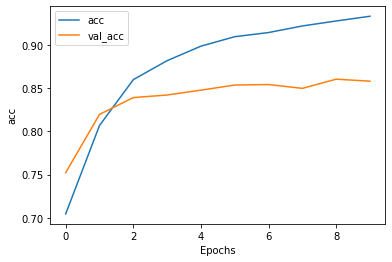

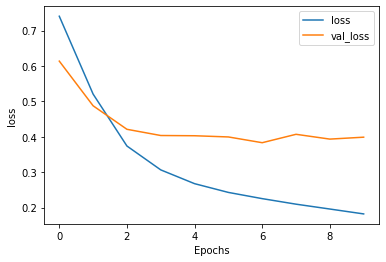

In [18]:
num_epochs = 10
history = model.fit(train_padded, train_lables_padded, epochs = num_epochs, validation_data=(validation_padded, padded_validation_label_seq), verbose = 2)

plot_graphs(history, "acc")
plot_graphs(history, "loss")